In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [3]:
aapl = pd.read_csv('AAPL_CLOSE', index_col = 'Date', parse_dates=True)
cisco = pd.read_csv('CISCO_CLOSE', index_col = 'Date', parse_dates=True)
ibm = pd.read_csv('IBM_CLOSE', index_col = 'Date', parse_dates=True)
amzn = pd.read_csv('AMZN_CLOSE', index_col = 'Date', parse_dates=True)

In [11]:
stocks = pd.concat([aapl, cisco, ibm, amzn], axis=1)
stocks = pd.DataFrame(stocks)
stocks.columns = ['AAPL', 'CISCO', 'IBM', 'AMZN']

In [12]:
log_ret = np.log((stocks/stocks.shift(1)))
log_ret.head()

,AAPL,CISCO,IBM,AMZN
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563
2012-01-06,0.010400,-0.003707,-0.011547,0.027763
2012-01-09,-0.001587,0.006346,-0.005218,-0.022428


In [13]:
np.random.seed(101)

num_ports = 5000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):
    
    weights = np.array(np.random.random((4)))
    weights = weights/np.sum(weights)
    

    all_weights[ind, :] = weights

    ret_arr[ind] = np.sum((log_ret.mean() * weights) * 252)

    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))

    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [14]:
sharpe_arr.max()

1.0303260551271065

In [15]:
sharpe_arr.argmax()

1420

In [16]:
all_weights[1420, :]

array([0.26188068, 0.20759516, 0.00110226, 0.5294219 ])

In [17]:
max_sr_ret = ret_arr[1420]
max_sr_vol = vol_arr[1420]

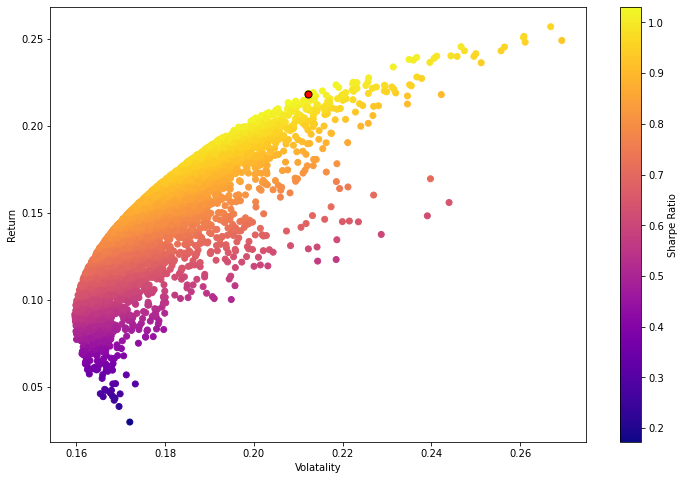

In [18]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatality')
plt.ylabel("Return")

plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolors='black')

In [19]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

In [20]:
from scipy.optimize import minimize

In [21]:
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

In [22]:
def check_sum(weights):
    # return 0 if the sum of the weights is 1
    return np.sum(weights) - 1

In [23]:
cons = ({'type': 'eq', 'fun': check_sum})

In [24]:
bounds = ((0,1), (0,1), (0,1), (0,1))

In [25]:
init_guess = [0.25, 0.25, 0.25, 0.25]

In [26]:
opt_results = minimize(neg_sharpe, init_guess, method = 'SLSQP', bounds = bounds, constraints=cons)

In [27]:
opt_results

     fun: -1.0307168703360547
     jac: array([ 5.64157963e-05,  4.18275595e-05,  3.39921698e-01, -4.44948673e-05])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.26628977, 0.20418982, 0.        , 0.52952041])

In [28]:
opt_results.x

array([0.26628977, 0.20418982, 0.        , 0.52952041])

In [29]:
get_ret_vol_sr(opt_results.x)

array([0.21885916, 0.21233683, 1.03071687])

In [30]:
frontier_y = np.linspace(0, 0.3, 100)

In [31]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [33]:
frontier_volatility = []

for possible_return in frontier_y:
    cons = ({'type' : 'eq', 'fun' : check_sum}, {'type' : 'eq', 'fun' : lambda w : get_ret_vol_sr(w)[0]-possible_return})
    
    result = minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    
    frontier_volatility.append(result['fun'])

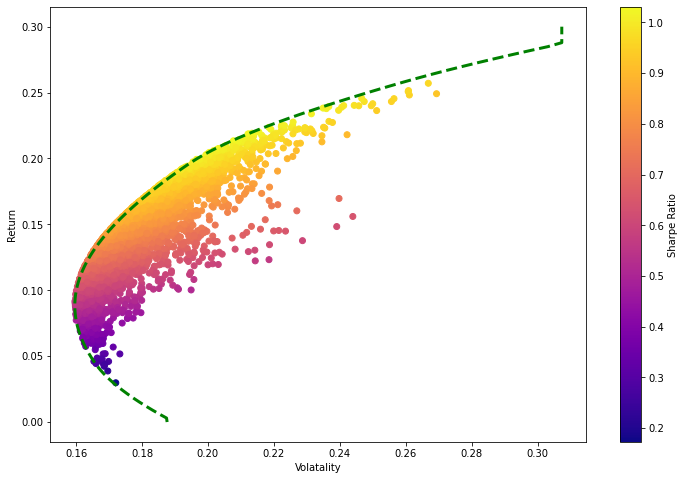

In [34]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatality')
plt.ylabel("Return")

plt.plot(frontier_volatility, frontier_y, 'g--', linewidth = 3)

array([0.26628977, 0.20418982, 0.        , 0.52952041])